<a href="https://colab.research.google.com/github/AnxietySquid/receipt_recognition/blob/main/OCR_receipt_easyocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ покупок по фотографии чека

В данном блокноте предоставляется код, который обрабатывает изображение, выводит список покупок, их стоимости и сумму.  Интерфейс для взимодействия можно найти внизу страницы, для использования необходимо выполнить все ячейки блокнота.  
На данный момент код имеет технические ограничения по точности распознавания, а также некоторое количество неиспользуемого кода, оставленного для улучшения анализа.

In [ ]:
# Библиотека оптического распознавания символов
!pip install -q easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import io
from PIL import Image
from IPython.display import display
import ast
from google.colab.patches import cv2_imshow
import cv2
from tqdm.notebook import tqdm
import re
#np.random.seed(42)

## Загрузка данных

In [ ]:
splits = {'train': 'data/train-00000-of-00001-a74fc0de5d4fea86.parquet', 'test': 'data/test-00000-of-00001-93911e4981641930.parquet', 'valid': 'data/valid-00000-of-00001-93911e4981641930.parquet'}
url = "hf://datasets/mychen76/receipt_cord_ocr_v2/"
train_df = pd.read_parquet(url + splits["train"])
valid_df = pd.read_parquet(url + splits["valid"])
test_df = pd.read_parquet(url + splits["test"])

In [ ]:
# Изображения загружаются в бинаре,
# другие столбцы - json записи с bounding box'ами и словами в них
train_df.head()

image   id  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    0   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    1   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   10   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  100   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  101   

                                         parsed_data  \
0  {"xml": "", "json": "\"{\\\"line_items\\\": [{...   
1  {"xml": "", "json": "\"{\\\"line_items\\\": [{...   
2  {"xml": "", "json": "\"{\\\"line_items\\\": {\...   
3  {"xml": "", "json": "\"{\\\"line_items\\\": {\...   
4  {"xml": "", "json": "\"{\\\"line_items\\\": {\...   

                                            raw_data  
0  {"ocr_words": "['1%', 'Nasi Campur Bali', '75,...  
1  {"ocr_words": "['1', 'SPGTHY BOLOGNASE', '58,0...  
2  {"ocr_words": "['1Viet Hilk Coffee', '25.000',...  
3  {"ocr_words": "['2 SAM DA SOO MINERAL WATER', ...  
4  {"ocr_words": "['ES CHOCO GREEN TEA', '13.000'...

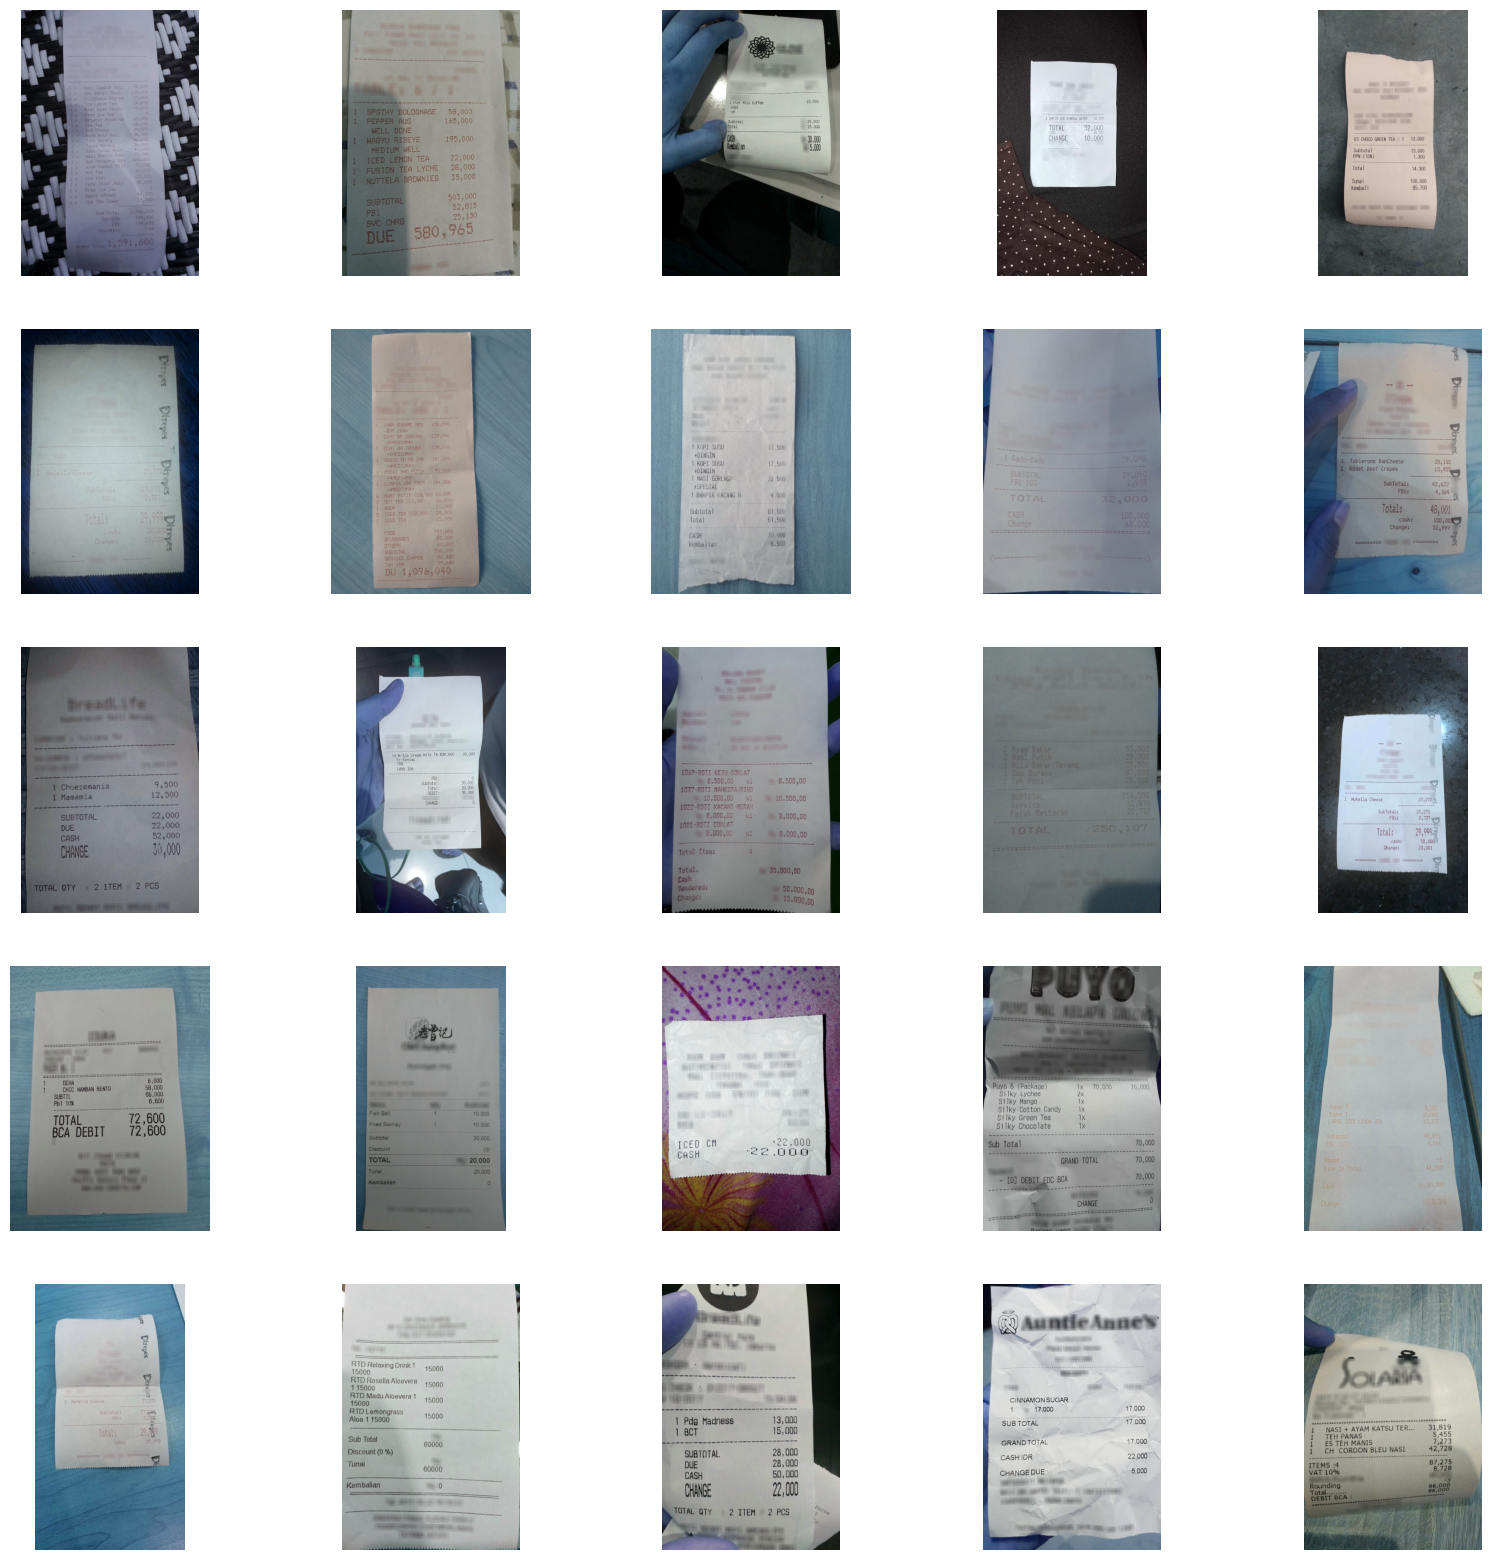

In [ ]:
# Отобразим первые 25 изображений для наглядности
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
for img_idx in range(25):
  data = train_df.iloc[img_idx, 0]
  img_array = np.frombuffer(data['bytes'], dtype=np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
  axs[img_idx].imshow(img)
  axs[img_idx].axis('off')

plt.show()

In [ ]:
n = 0
data = train_df.iloc[n, 0]
img_array = np.frombuffer(data['bytes'], dtype=np.uint8)
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

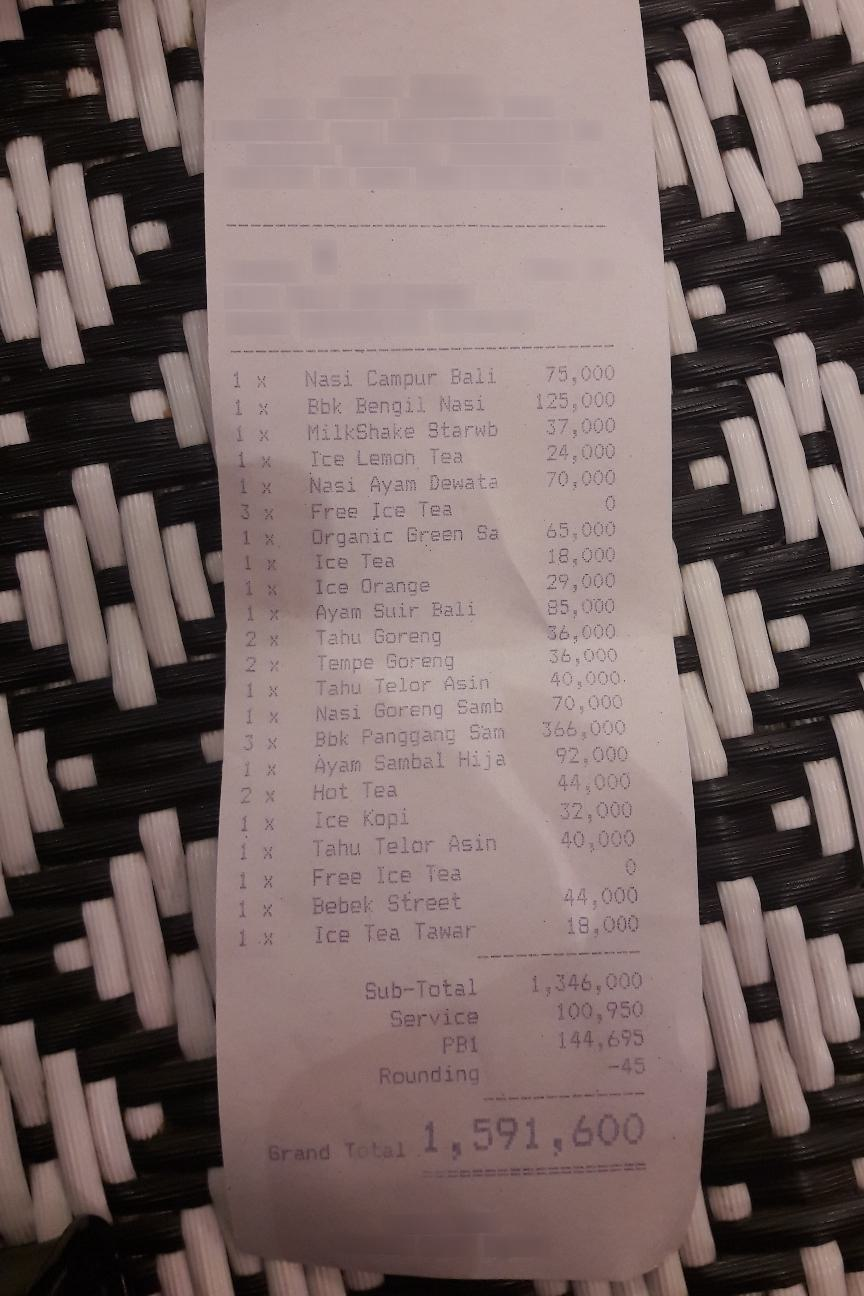

In [ ]:
cv2_imshow(image)

## EasyOCR

На данных изображениях было принято решение использовать именно EasyOCR, так как
данная библеотка быстрее прочих выполняет анализ изображения.  
OCR на основе трансформеров намного "тяжелее" и не позволят выполнять код на смартфоне локально за разумное время.  
Согласно ТЗ https://colab.research.google.com/drive/10-3ZEHIu38UuBGU1dbRkTbU-4Y9s8ZfU?usp=sharing, вся необходимая информация должна появиться в базе данных в течение минуты

In [ ]:
import easyocr

In [ ]:
# Инициализация ридера, языки выбираются первым позиционным параметров в списке
reader = easyocr.Reader(['en'])

In [ ]:
%%time
# Достаточно объёмный чек считался за 33с на CPU, хороший результат
# Точно такой же снимок на OCR на основе трансфомера занял более двух минут
result = reader.readtext(image)

CPU times: user 24.2 s, sys: 5.57 s, total: 29.8 s
Wall time: 33.3 s


In [ ]:
def draw_bounding_boxes(image, detections, threshold=0.25):
  for bbox, text, score in detections:
    cv2.rectangle(image, tuple(map(int, bbox[0])), tuple(map(int, bbox[2])), (0, 0, 255), 5)
    cv2.putText(image, text, tuple(map(int, bbox[0])), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.65, (255, 0, 0), 2)

In [ ]:
draw_bounding_boxes(image, result)

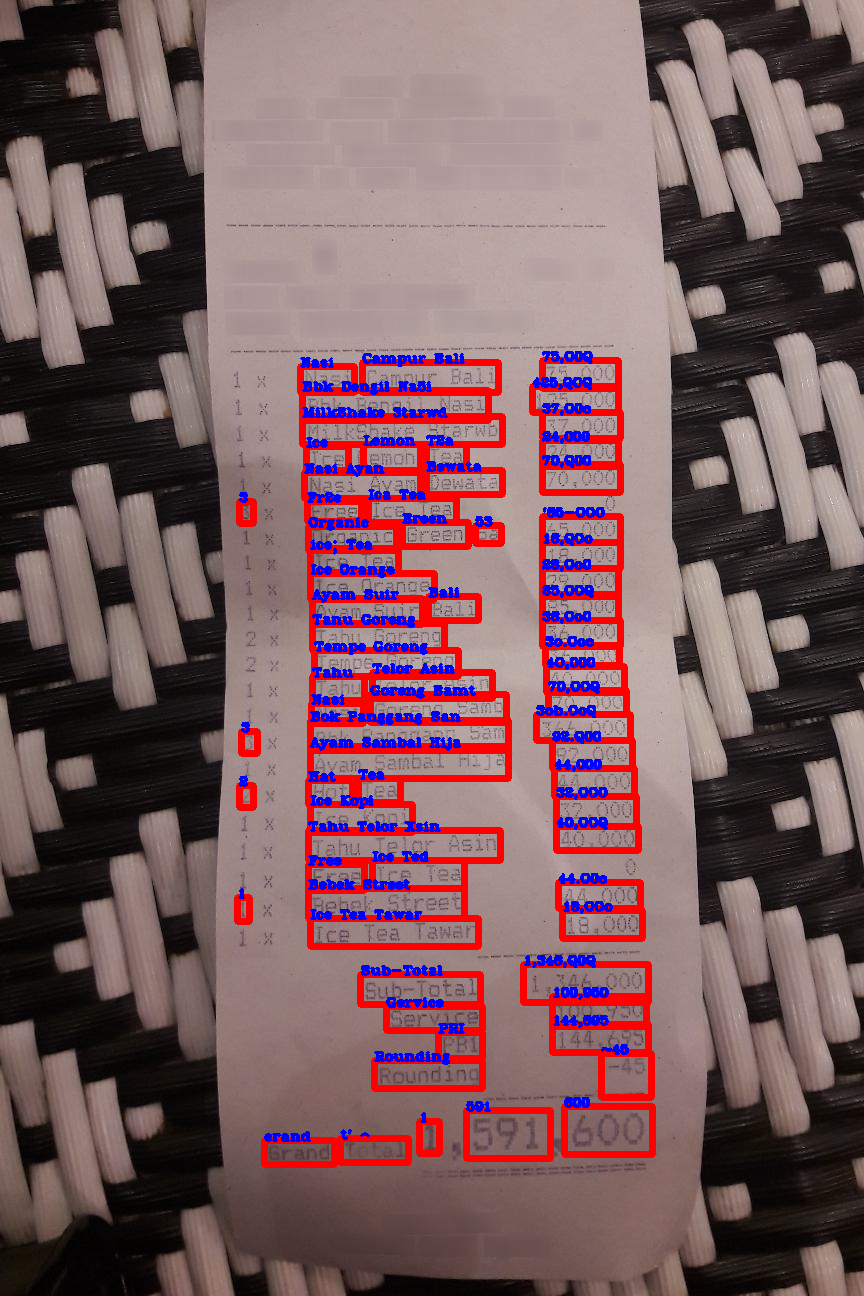

In [ ]:
cv2_imshow(cv2.cvtColor(image, cv2.IMREAD_COLOR))

## Обработка результатов

За неимением трансформера, все результаты анализа обрабатываются в полуручном режиме с использованием регулярных выражений, отсюда происходит главное техническое ограничение этого инструмента на данном этапе: между наименованием товара и его стоимостью не должно находиться другого текста

In [ ]:
# Забираем из результатов только текст в найденных полях
pos_list = []
for i in result:
  if len(i[-2].strip()) > 2:
    pos_list.append(i[-2])

In [ ]:
pos_list

['Nasi',
 'Campur Bali',
 '75,O0Q',
 'Bbk Dengil Na5i',
 '425,QOQ',
 'MilkShake 3tarwd',
 '37,O0o',
 'Ice',
 'Lemon',
 'T2a',
 '24,000',
 'Nasi Ayan',
 'Bewata',
 '70,Q00',
 'Fr2e',
 'Ica Tea',
 'Organic',
 'Ereen',
 "'65-OOO",
 'ice; Tea',
 '16,QOo',
 'Ice Orange',
 '28,Oo0',
 'Ayam Suir',
 'Bali',
 '85,OOQ',
 'Tanu Goreng',
 '36,Oo0',
 'Tempe Goreng',
 '3o.Ooo',
 'Tahu',
 'Telor Asin',
 '4O,000',
 'Nasi',
 'Goreng Bamt',
 '70,OOQ',
 'Bok Panggang San',
 '3ob.OoQ',
 'Ayam Sambal Hija',
 '92.Q00',
 'Hat',
 'Tea',
 '44,000',
 'Ice Kopi',
 '32,OOO',
 'Tahu Telor Xsin',
 '40,OOQ',
 'Free',
 'Ice Ted',
 'Bebek Street',
 '44.O0o',
 'Ice Tea Tawar',
 '18,OOo',
 'Sub-Total',
 '1,346,Q0Q',
 'Gervice',
 '100,950',
 'PRI',
 '144,695',
 'Rounding',
 '~45',
 'erand',
 "t' ^",
 '591',
 '600']

In [ ]:
def clean_price(raw):
    # Обрабатывать дальше только если в тексте нет запятой или точки
    # Это необходимо для обработки только стоимостей
    if ',' not in raw and '.' not in raw:
        return None

    # Приводим к верхнему регистру и заменяем символы на числа, которые
    # похожи друг на друга
    raw = raw.upper()
    raw = raw.replace('O', '0')
    raw = raw.replace('Q', '0')
    raw = raw.replace('@', '0')
    raw = raw.replace('I', '1')
    raw = raw.replace('L', '1')
    raw = raw.replace('Z', '2')
    raw = raw.replace('S', '5')
    raw = raw.replace('B', '8')

    # Оставляем только числа, запятые и точки после преобразования
    raw = re.sub(r"[^\d,\.]", "", raw)

    # Убираем разделительные знаки
    raw = raw.replace(",", "")
    raw = raw.replace(".", "")

    # Очищаем от других ненужных символов по краям строки
    raw = raw.strip("'\"-:; ")

    # Пытаемся конвертировать во float
    try:
        return float(raw)
    except:
        return None


In [ ]:
# Остаются только стоимости, на месте другого текста - None
cleaned = [clean_price(p) for p in pos_list]
print(pos_list)
print(cleaned)

['Nasi', 'Campur Bali', '75,O0Q', 'Bbk Dengil Na5i', '425,QOQ', 'MilkShake 3tarwd', '37,O0o', 'Ice', 'Lemon', 'T2a', '24,000', 'Nasi Ayan', 'Bewata', '70,Q00', 'Fr2e', 'Ica Tea', 'Organic', 'Ereen', "'65-OOO", 'ice; Tea', '16,QOo', 'Ice Orange', '28,Oo0', 'Ayam Suir', 'Bali', '85,OOQ', 'Tanu Goreng', '36,Oo0', 'Tempe Goreng', '3o.Ooo', 'Tahu', 'Telor Asin', '4O,000', 'Nasi', 'Goreng Bamt', '70,OOQ', 'Bok Panggang San', '3ob.OoQ', 'Ayam Sambal Hija', '92.Q00', 'Hat', 'Tea', '44,000', 'Ice Kopi', '32,OOO', 'Tahu Telor Xsin', '40,OOQ', 'Free', 'Ice Ted', 'Bebek Street', '44.O0o', 'Ice Tea Tawar', '18,OOo', 'Sub-Total', '1,346,Q0Q', 'Gervice', '100,950', 'PRI', '144,695', 'Rounding', '~45', 'erand', "t' ^", '591', '600']
[None, None, 75000.0, None, 425000.0, None, 37000.0, None, None, None, 24000.0, None, None, 70000.0, None, None, None, None, None, None, 16000.0, None, 28000.0, None, None, 85000.0, None, 36000.0, None, 30000.0, None, None, 40000.0, None, None, 70000.0, None, 308000.0, Non

In [ ]:
def group_items_and_prices(tokens):
    '''
    Принимает результат обработки
    Возвращает список из кортежей "товар, цена"
    '''
    items = []
    current_item = []
    for token in tokens:
        cleaned = clean_price(token)
        if cleaned is not None:
            if current_item:
                item_name = " ".join(current_item)
                items.append((item_name, cleaned))
                current_item = []
        else:
            current_item.append(token)
    return items


In [ ]:
group_items_and_prices(pos_list)

[('Nasi Campur Bali', 75000.0),
 ('Bbk Dengil Na5i', 425000.0),
 ('MilkShake 3tarwd', 37000.0),
 ('Ice Lemon T2a', 24000.0),
 ('Nasi Ayan Bewata', 70000.0),
 ("Fr2e Ica Tea Organic Ereen '65-OOO ice; Tea", 16000.0),
 ('Ice Orange', 28000.0),
 ('Ayam Suir Bali', 85000.0),
 ('Tanu Goreng', 36000.0),
 ('Tempe Goreng', 30000.0),
 ('Tahu Telor Asin', 40000.0),
 ('Nasi Goreng Bamt', 70000.0),
 ('Bok Panggang San', 308000.0),
 ('Ayam Sambal Hija', 92000.0),
 ('Hat Tea', 44000.0),
 ('Ice Kopi', 32000.0),
 ('Tahu Telor Xsin', 40000.0),
 ('Free Ice Ted Bebek Street', 44000.0),
 ('Ice Tea Tawar', 18000.0),
 ('Sub-Total', 1346000.0),
 ('Gervice', 100950.0),
 ('PRI', 144695.0)]

In [ ]:
SUMMARY_KEYWORDS = [
    "SUBTOTAL", "TOTAL", "TAX", "SERVICE", "SVC", "CHRG", "DUE", "PBI", "PB1",
    "AMOUNT", "BALANCE", "GERVICE"
]

In [ ]:
def is_summary_line(text):
    # Проверка, является ли строка - суммой в чеке
    text = text.upper()
    return any(keyword in text for keyword in SUMMARY_KEYWORDS)

def filter_summary_items(item_price_list):
    result = []
    for item, price in item_price_list:
        if is_summary_line(item):
            break  # Прекращаем добавлять элементы, если встретили суммирующую строку
        result.append((item, price))
    return result


In [ ]:
filter_summary_items(group_items_and_prices(pos_list))

[('Nasi Campur Bali', 75000.0),
 ('Bbk Dengil Na5i', 425000.0),
 ('MilkShake 3tarwd', 37000.0),
 ('Ice Lemon T2a', 24000.0),
 ('Nasi Ayan Bewata', 70000.0),
 ("Fr2e Ica Tea Organic Ereen '65-OOO ice; Tea", 16000.0),
 ('Ice Orange', 28000.0),
 ('Ayam Suir Bali', 85000.0),
 ('Tanu Goreng', 36000.0),
 ('Tempe Goreng', 30000.0),
 ('Tahu Telor Asin', 40000.0),
 ('Nasi Goreng Bamt', 70000.0),
 ('Bok Panggang San', 308000.0),
 ('Ayam Sambal Hija', 92000.0),
 ('Hat Tea', 44000.0),
 ('Ice Kopi', 32000.0),
 ('Tahu Telor Xsin', 40000.0),
 ('Free Ice Ted Bebek Street', 44000.0),
 ('Ice Tea Tawar', 18000.0)]

Под суммирующей строкой подразумевается вся информация внизу чека, которая идёт после перечисления товаров

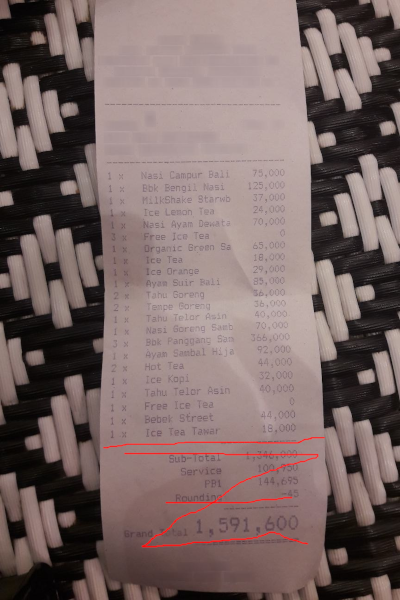

In [ ]:
#@title Соберём всё воедино
SUMMARY_KEYWORDS = [
    "SUBTOTAL", "TOTAL", "TAX", "SERVICE", "SVC", "CHRG", "DUE", "PBI", "PB1",
    "AMOUNT", "BALANCE", "GERVICE"
]

def pull_positions_and_prices(image,
                              reader_lang=['en'],
                              summary_keywords=SUMMARY_KEYWORDS,

                              ):
  '''
  Принимает изображение, язык, список слов в суммаризирующей строке в чеке
  Возвращает список кортежей товар:цена, обработанное изображение с bbox'ами
  и сумму покупок
  '''
  reader = easyocr.Reader(reader_lang)
  result = reader.readtext(image)
  draw_bounding_boxes(image, result)

  pos_list = []
  for i in result:
    if len(i[-2].strip()) > 2:
      pos_list.append(i[-2])

  extracted = filter_summary_items(group_items_and_prices(pos_list))

  summ = 0
  for i in extracted:
    summ += i[1]

  return extracted, image, summ

# Интерфейс

In [ ]:
# Интерфейс отображения результата для работы пользователя
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from PIL import Image

# Your actual prediction function
def predict(image: Image.Image):
    # Do OCR or processing here
    extracted_text, bbox_img, summary = pull_positions_and_prices(image)
    print(type(bbox_img))

    return str(summary), str(extracted_text), bbox_img

# Gradio interface with two outputs
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=[
        gr.Textbox(label="Сумма покупок"),
        gr.Textbox(label="Распознанные позиции и цены"),
        gr.Image(type="numpy", label="Обработанное изображение")
    ],
    submit_btn="Анализ",
    clear_btn="Сброс",
    title="Подсчёт суммы покупок",
    description="Загрузите изображение чека для анализа"
)

iface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c616b16f06b6464df8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7864 <> https://c616b16f06b6464df8.gradio.live


# Планы на будущие реализации

1. Дообучить ядро распознавания EasyOCR
2. Выводить информацию в гугл-таблицу